In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mode,skew,skewtest

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold,train_test_split
import xgboost as xgb

In [2]:
data=pd.read_csv('/Users/adityavyas/Desktop/Machine Learning and Big Data/Datasets/Human Resource/HR_comma_sep.csv')

In [3]:
data.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [5]:
data.shape

(14999, 10)

In [6]:
data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

In [7]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [8]:
#We first split the data into training and testing sets

train,test=train_test_split(data,train_size=0.95,test_size=0.05)
train.size,test.size

(142490, 7500)

In [9]:
#We see that the avg monthly hours has a higher data amount and thus we will have to scale the data afterwards
#We run a basic random forest to determine the feature importances

forest=RandomForestClassifier(n_estimators=100,n_jobs=-1)
forest.fit(train.drop(['left','salary','sales'],1),train['left'])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<Container object of 7 artists>

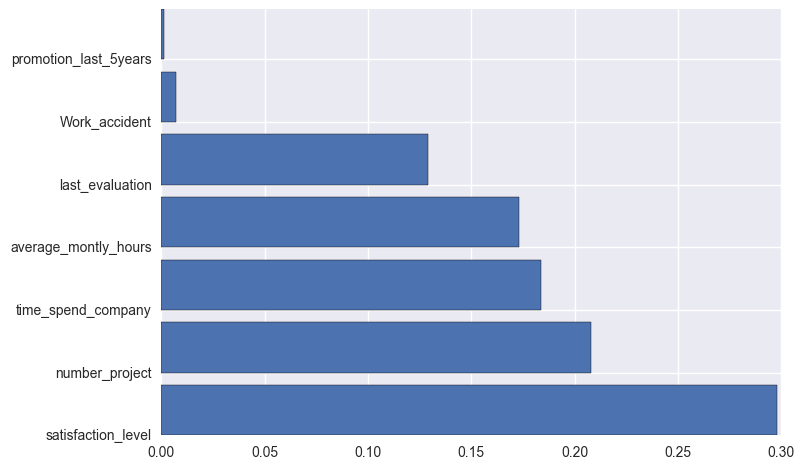

In [10]:
importances=forest.feature_importances_
indices=np.argsort(importances)[::-1]
feature=train.drop(['left','salary','sales'],1).columns
plt.yticks(range(len(indices)),feature[indices],fontsize=10)
plt.barh(range(len(indices)),importances[indices])
#plt.tick_params(axis='x',)
#plt.tight_layout()

In [11]:
#As we see the above features have the respective importances.Satisfaction level has the highest importance as is clear
#logically.Lets examine each feature 

#satisfaction_level - we set a threshold of 0.5 for satisfaction level

def set_threshold(x):
    if x['satisfaction_level']>0.5:
        x['satisfy_new']=1.0
    else:
        x['satisfy_new']=0.0
    return x
train=train.apply(lambda x:set_threshold(x),1)

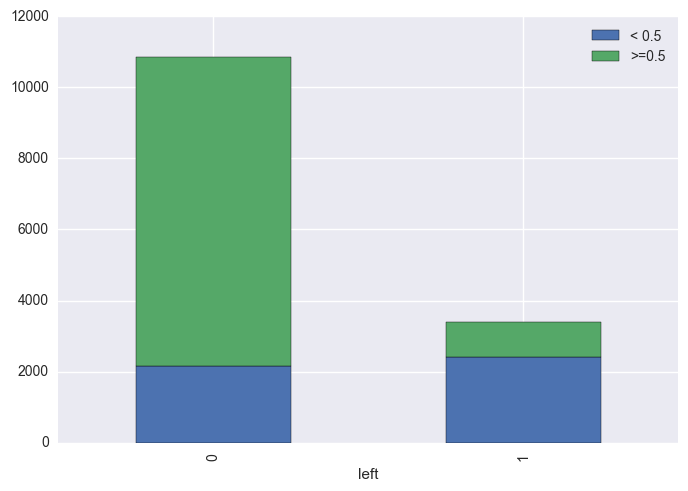

In [12]:
#We plot the variation of satisfaction level with the leaving of the employee

pd.crosstab(train['left'],train['satisfy_new']).plot(kind='bar',stacked=True)
plt.legend(['< 0.5','>=0.5'])

In [13]:
#Thus we see that of the people who have stayed here most have a higher satisfaction and hence it is important to our
#prediction

#number of projects

train.drop('satisfy_new',1,inplace=True)
train['number_project'].value_counts()

4    4164
3    3838
5    2634
2    2260
6    1113
7     240
Name: number_project, dtype: int64

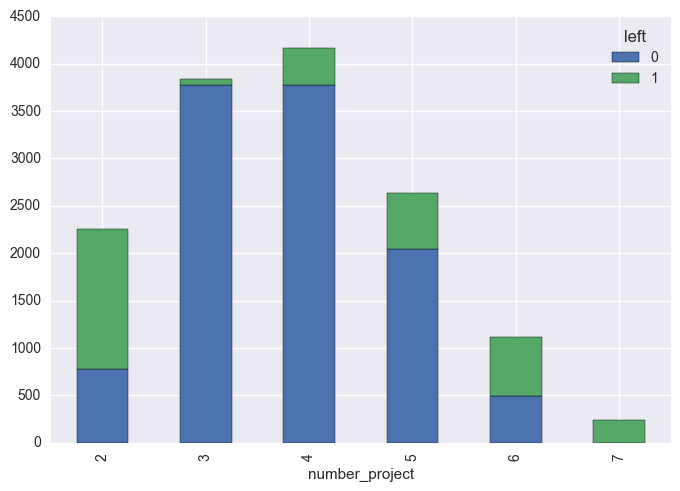

In [14]:
#For number of projects we check how the number of projects have had an impact on whether they have left or not
pd.crosstab(train['number_project'],train['left'],).plot(kind='bar',stacked=True)

/Users/adityavyas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


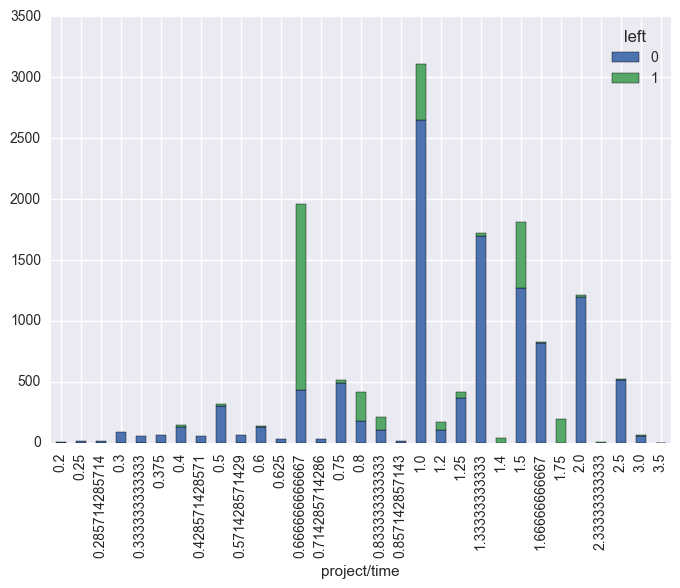

In [15]:
#We see that those who did 3 projects have stayed and the percentage of people who are leaving increases with increasing
#projects.We create a new feature which calculates the number of project per time for which the person works

train['project/time']=train['number_project']/train['time_spend_company']
test['project/time']=test['number_project']/test['time_spend_company']
pd.crosstab(train['project/time'],train['left']).plot(kind='bar',stacked=True)

In [16]:
#We see that there are only binary values


train['Work_accident'].value_counts()

0    12200
1     2049
Name: Work_accident, dtype: int64

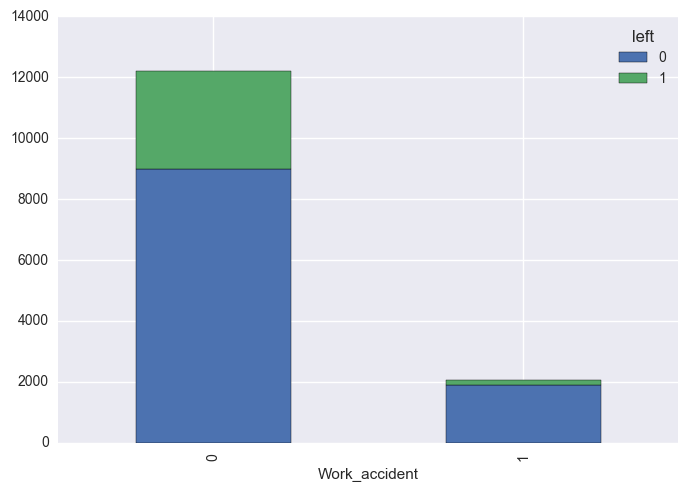

In [17]:
pd.crosstab(train['Work_accident'],train['left'],).plot(kind='bar',stacked=True)

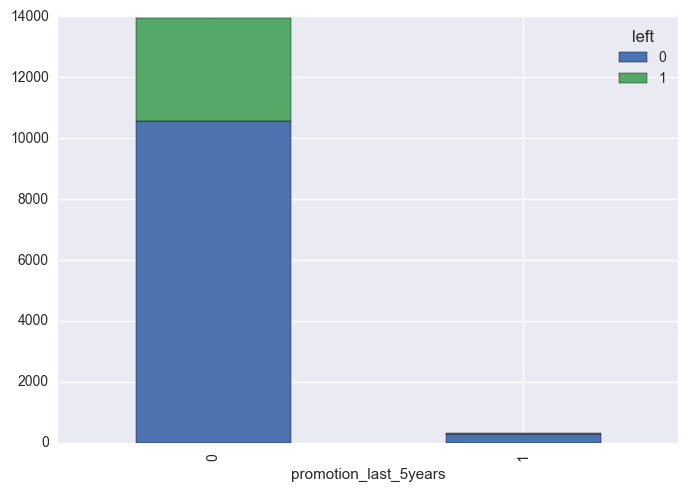

In [18]:
#We see that in those who have had work accidents and those who havent there is no logical relationship with Left.

#Promotion last 5 years

pd.crosstab(train['promotion_last_5years'],train['left']).plot(kind='bar',stacked=True)

In [19]:
#We see that those who had a promotion in the last 5 years all stayed but a significant number of those didnt have a 
#promotion also stayed.Lets look at last evaluation

def set_threshold_for_evaluation(x):
    if x['last_evaluation']>0.5:
        x['eval_new']=1.0
    else:
        x['eval_new']=0.0
    return x
train=train.apply(lambda x:set_threshold_for_evaluation(x),1)

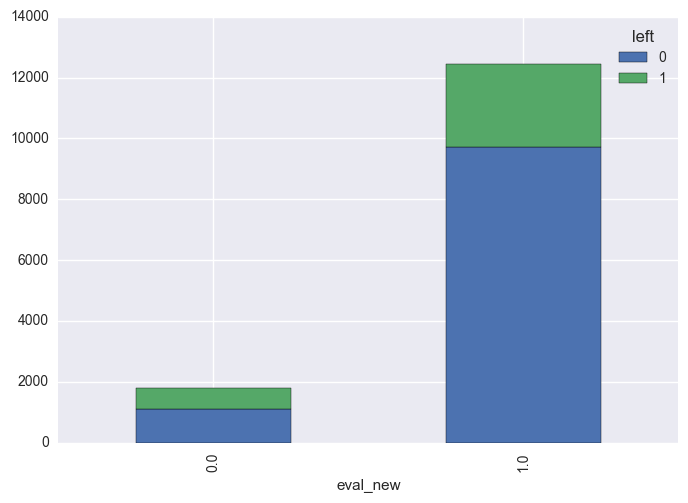

In [20]:
pd.crosstab(train['eval_new'],train['left']).plot(kind='bar',stacked=True)

In [21]:
pd.crosstab(train['left'],train['eval_new'])

eval_new,0.0,1.0
left,,
0,1129,9736
1,680,2704


In [22]:
#percentage of people who left and had evaluations greater than 0.5
percent1=9719.0/(2707+9719)

#percentage of people who left and had evaluations less 0.5
percent2=1138.0/(1138.0+685.0)

percent1,percent2

(0.7821503299533237, 0.6242457487657707)

In [23]:
#We see that the evaluations did not have any significant effect on whether the people left or not

train.drop('eval_new',1,inplace=True)

In [24]:
#Sales

train['sales'].value_counts()

sales          3937
technical      2578
support        2105
IT             1156
product_mng     852
marketing       823
RandD           759
accounting      728
hr              707
management      604
Name: sales, dtype: int64

In [25]:
train.head(1)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,project/time
10506,0.84,0.85,5,246,3,0,0,0,support,medium,1.666667


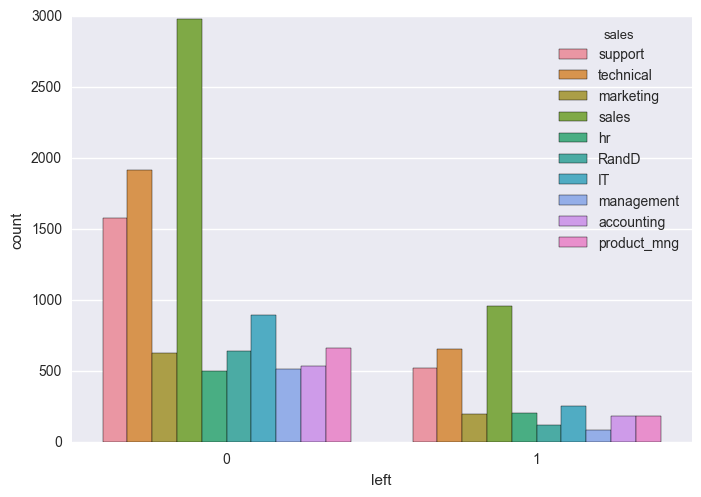

In [26]:
sns.countplot('left',data=train,hue='sales')

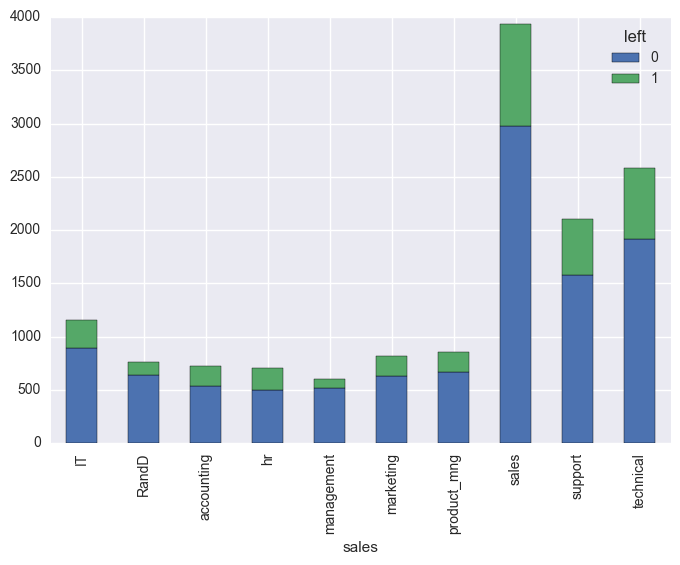

In [27]:
pd.crosstab(train['sales'],train['left']).plot(kind='bar',stacked=True)

In [28]:
#We observe that people in sales department have higher percentage of those who have left, followed by support and tech
# -cal 

#Salary

train['salary'].value_counts()

low       6930
medium    6142
high      1177
Name: salary, dtype: int64

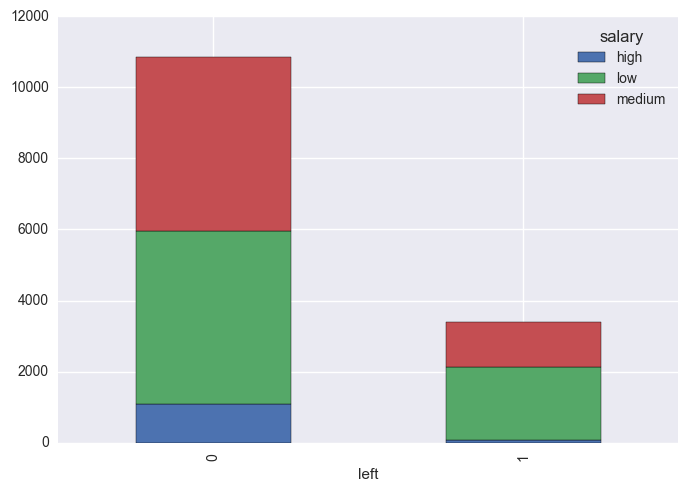

In [29]:
pd.crosstab(train['left'],train['salary']).plot(kind='bar',stacked=True)

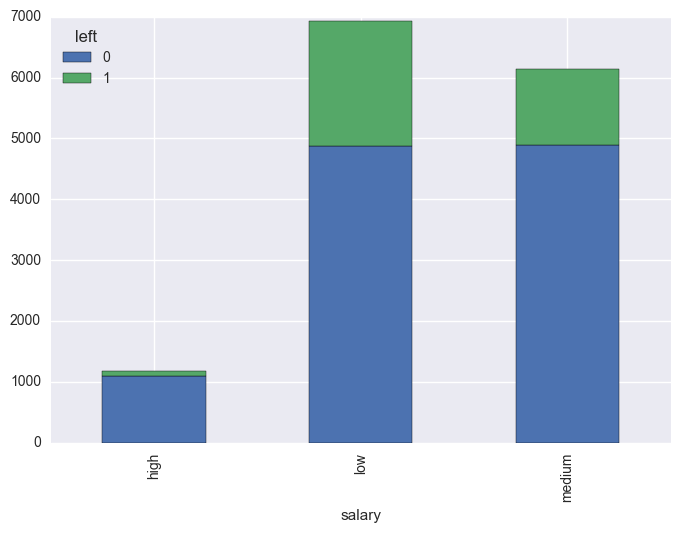

In [30]:
pd.crosstab(train['salary'],train['left']).plot(kind='bar',stacked=True)

In [31]:
#Time spent at the company

train['time_spend_company'].value_counts()

3     6134
2     3064
4     2436
5     1405
6      683
10     196
7      176
8      155
Name: time_spend_company, dtype: int64

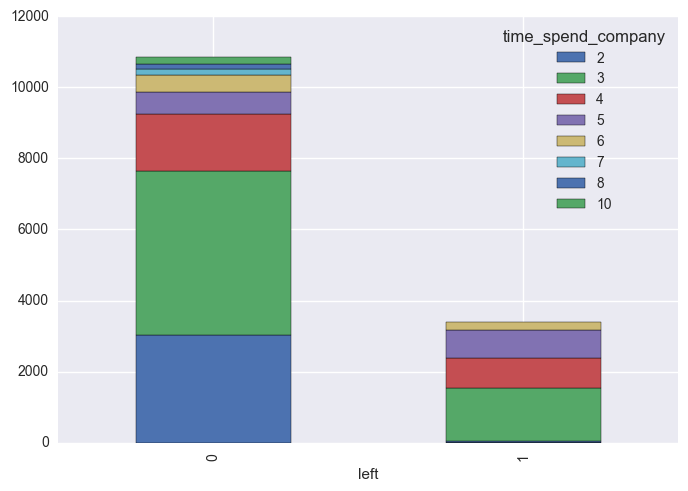

In [32]:
pd.crosstab(train['left'],train['time_spend_company']).plot(kind='bar',stacked=True)

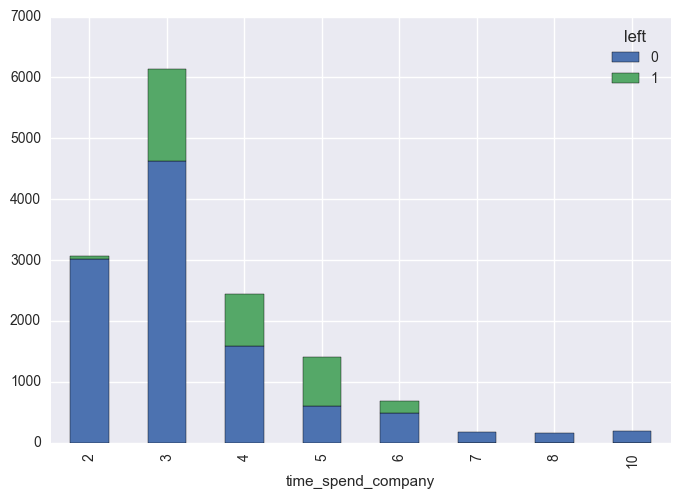

In [33]:
pd.crosstab(train['time_spend_company'],train['left']).plot(kind='bar',stacked=True)

In [34]:
#We see that majority of people who have left are from those who spent little time at the company. Experienced and olde
#employees have all stayed. New ones have also stayed.

#Average Monthly Hours

train['average_montly_hours'].value_counts()

135    146
156    142
149    141
151    140
160    128
145    126
260    121
143    121
140    120
157    119
257    118
245    118
153    118
148    118
155    117
137    117
159    117
154    115
139    114
134    112
158    111
224    111
141    109
147    108
243    108
255    108
254    108
142    106
152    106
247    106
      ... 
101     16
103     15
291     15
114     14
294     14
292     14
124     13
293     13
307     13
298     13
290     13
115     12
97      12
118     12
295     11
300     11
99      11
110     11
122     11
120     10
107     10
119     10
116     10
112      8
302      7
303      6
288      6
297      6
299      6
96       5
Name: average_montly_hours, dtype: int64

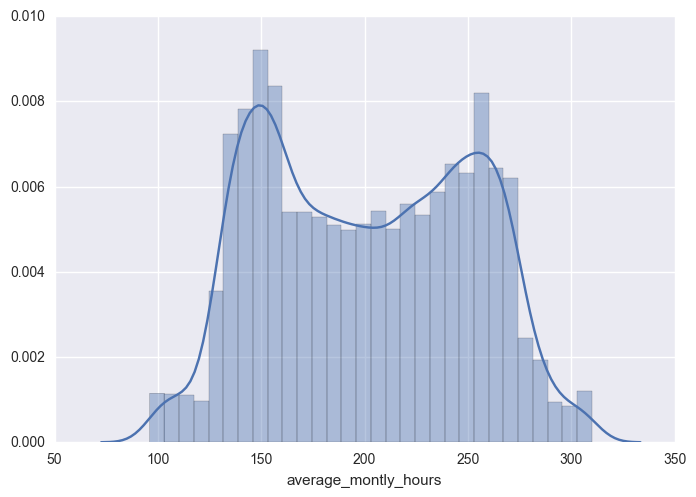

In [35]:
sns.distplot(train['average_montly_hours'])

In [36]:
#Assuming the time_spent_at company to be years we can calculate the number of months the person worked at the company.

train['num_months']=train['time_spend_company']*12
test['num_months']=test['time_spend_company']*12


/Users/adityavyas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [37]:
lb=LabelEncoder()
train['sales_new']=lb.fit_transform(train['sales'])
train['salary_new']=lb.fit_transform(train['salary'])
train.drop(['sales','salary'],1,inplace=True)

test['sales_new']=lb.fit_transform(test['sales'])
test['salary_new']=lb.fit_transform(test['salary'])
test.drop(['sales','salary'],1,inplace=True)

/Users/adityavyas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adityavyas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adityavyas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [38]:
train.head(1)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,project/time,num_months,sales_new,salary_new
10506,0.84,0.85,5,246,3,0,0,0,1.666667,36,8,2


In [39]:
X_TRAIN,Y_TRAIN=train.drop('left',1),train['left']
x_test,y_test=test.drop('left',1),test['left']

train_,val=train_test_split(train,train_size=0.8)
x_train,y_train=train_.drop('left',1),train_['left']
x_val,y_val=val.drop('left',1),val['left']

In [40]:
#Logistic Regression

from sklearn import linear_model,metrics
logreg=linear_model.LogisticRegression(C=100.0,max_iter=500)
logreg.fit(x_train,y_train)
y_pred_val1=logreg.predict(x_val)
val_accuracy1=metrics.accuracy_score(y_pred_val1,y_val)

y_pred_test1=logreg.predict(x_test)
test_accuracy1=metrics.accuracy_score(y_pred_test1,y_test)
'validation accuracy= '+str(val_accuracy1)+'   '+'final accuracy= '+str(test_accuracy1)

'validation accuracy= 0.877543859649   final accuracy= 0.866666666667'

In [41]:
#Random Forest Classifier

from sklearn import ensemble
forest=ensemble.RandomForestClassifier(n_estimators=100)
forest.fit(x_train,y_train)
y_pred_val2=forest.predict(x_val)
val_accuracy2=metrics.accuracy_score(y_pred_val2,y_val)

y_pred_test2=forest.predict(x_test)
test_accuracy2=metrics.accuracy_score(y_pred_test2,y_test)
'validation accuracy= '+str(val_accuracy2)+'   '+'final accuracy= '+str(test_accuracy2)

'validation accuracy= 0.988771929825   final accuracy= 0.989333333333'

In [42]:
#Support Vector Machine

from sklearn import svm

sv=svm.SVC()
sv.fit(x_train,y_train)
y_pred_val3=sv.predict(x_val)
val_accuracy3=metrics.accuracy_score(y_pred_val3,y_val)

y_pred_test3=forest.predict(x_test)
test_accuracy3=metrics.accuracy_score(y_pred_test3,y_test)
'validation accuracy= '+str(val_accuracy3)+'   '+'final accuracy= '+str(test_accuracy3)

'validation accuracy= 0.950877192982   final accuracy= 0.989333333333'

In [43]:
#Now we remove the 2 least important features

train2=train.drop(['promotion_last_5years','Work_accident'],1)
test2=test.drop(['promotion_last_5years','Work_accident'],1)


In [44]:
X_TRAIN2,Y_TRAIN2=train2.drop('left',1),train2['left']
x_test2,y_test2=test2.drop('left',1),test2['left']

train2_,val2=train_test_split(train2,train_size=0.8)
x_train2,y_train2=train2_.drop('left',1),train2_['left']
x_val2,y_val2=val2.drop('left',1),val2['left']

In [45]:
#Random Forest Classifier

from sklearn import ensemble
forest=ensemble.RandomForestClassifier(n_estimators=100)
forest.fit(x_train2,y_train2)
y_pred_val2=forest.predict(x_val2)
val_accuracy2=metrics.accuracy_score(y_pred_val2,y_val2)

y_pred_test2=forest.predict(x_test2)
test_accuracy2=metrics.accuracy_score(y_pred_test2,y_test2)
'validation accuracy= '+str(val_accuracy2)+'   '+'final accuracy= '+str(test_accuracy2)

'validation accuracy= 0.989122807018   final accuracy= 0.985333333333'

In [ ]:
#XGBoost

from sklearn import ensemble
xgb_model=xgb.XGBClassifier(n_estimators=100)
xgb_model.fit(x_train2,y_train2)
y_pred_val3=forest.predict(x_val2)
val_accuracy3=metrics.accuracy_score(y_pred_val3,y_val2)

y_pred_test3=xgb_model.predict(x_test2)
test_accuracy3=metrics.accuracy_score(y_pred_test2,y_test2)
'validation accuracy= '+str(val_accuracy2)+'   '+'final accuracy= '+str(test_accuracy2)